First, import necessary libraries.

In [55]:
import sys
import os
import json
import math
import re
import itertools
from copy import deepcopy
from collections import defaultdict
from dataclasses import dataclass
from datetime import timedelta, datetime

## Core Data Science Libraries

# Main matplotlib usage is with `plt.whatever`
import matplotlib.pyplot as plt
# Sometimes you need style stuff via `mpl.whatever`
import matplotlib as mpl
# Statistic functions like `st.f_oneway`, `st.pearsonr`, etc.
import scipy.stats as st
# Your entire life is now pd.DataFrame(), pd.concat, etc.
import pandas as pd
# Real plotters user Seaborn over Matplotlib: sns.histplot, sns.jointplot, sns.lmplot, etc.
import seaborn as sns
# Sometimes you have to use numpy stuff, but almost always better to stay in Pandas
import numpy as np
# Specifically for IRR calculation
import krippendorff

## Quality of Life Libraries

# Progress bars! Just do:
#   for an_item in tqdm(an_iterable):
from tqdm.notebook import tqdm

# Need to render HTML or Code? Combine them with `display`
# Sometimes you will want to `print`, and sometimes `display`
from IPython.display import display, HTML, Code

## More Situational Libraries

# Situational, but sometimes natsorting is helpful
from natsort import index_natsorted, natsorted, order_by_index, natsort_keygen

# Some more useful statistic related functions in here
import sklearn.metrics as metrics

# More stats stuff, mixed effects models, generalized linear models, ODEs, etc.
import statsmodels as sm

# Probably won't need to use hidden markov models
#from hmmlearn import hmm

Style graphs to look more like the surrounding paper.

In [56]:
# At the minimum, make the background white so you can copy/paste into Discord :)
mpl.rcParams['figure.facecolor'] = 'white'

# Calculations I did one time for LaTeX papers, hope they're accurate..?
COLUMN_WIDTH = 240/72.27
TEXT_WIDTH = 504/72.27

# I liked this style, but use your best judgement
plt.style.use('seaborn-v0_8-whitegrid')

# Setup nice fonts for an ACM LaTeX paper
nice_fonts = {
    # Ideally, you should enable this if you have LaTeX installed
    # It'll make the graphs match the paper font much more closely.
    # "text.usetex": True,
    "text.usetex": False,
    
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 10,
    "font.size": 10,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
}
mpl.rcParams.update(nice_fonts)

# Stop using scientific notation, show two decimal places instead.
pd.set_option('display.float_format', '{:.2f}'.format)

Some helper functions:

In [57]:
def save_figure(filename, fig=None, folder='reports/figures/'):
    """ Helper function to quickly save figures for the paper. """
    if fig is None:
        fig = plt
    fig.savefig(os.path.join(folder, filename), format='pdf', bbox_inches='tight')

def display_code(data):
    return display(Code(data))

display_code("a = 0")

def set_size(width, fraction=1, subplots=(1, 1)):
    """ Set figure dimensions to avoid scaling in LaTeX.
    Parameters
    ----------
    width: float or string
            Document width in points, or string of predefined document type
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy
    subplots: array-like, optional
            The number of rows and columns of subplots.
    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    if width == 'thesis':
        width_pt = 426.79135
    elif width == 'beamer':
        width_pt = 307.28987
    elif width == 'pnas':
        width_pt = 246.09686
    else:
        width_pt = width

    # Width of figure (in pts)
    fig_width_pt = width_pt * fraction
    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    golden_ratio = (5**.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio * (subplots[0] / subplots[1])

    return fig_width_in, fig_height_in

def tex_escape(text):
    """
        :param text: a plain text message
        :return: the message escaped to appear correctly in LaTeX
    """
    conv = {
        '&': r'\&',
        '%': r'\%',
        '$': r'\$',
        '#': r'\#',
        '_': r'\_',
        '{': r'\{',
        '}': r'\}',
        '~': r'\textasciitilde{}',
        '^': r'\^{}',
        '\\': r'\textbackslash{}',
        '<': r'\textless{}',
        '>': r'\textgreater{}',
    }
    regex = re.compile('|'.join(re.escape(str(key)) for key in sorted(conv.keys(), key = lambda item: - len(item))))
    return regex.sub(lambda match: conv[match.group()], text)

### Good Research Stuff
# Choose a consistent alpha threshold for P-Value calculations
ALPHA = .05

def proportion_stats(incidences, total, label=None):
    """ Pretty prints a proportion with APA-style statistics. """
    proportion = incidences/total
    rounded_proportion = round(100*proportion*10)/10
    standard_deviation = math.sqrt(proportion*(1-proportion))/math.sqrt(total)
    rounded_sd = round(100*standard_deviation)/100
    result = f"n={incidences}, M={rounded_proportion}%, SD={rounded_sd}"
    if label is None:
        return result
    else:
        print(label, result)
print(proportion_stats(50, 100))
proportion_stats(75, 103, 'Test Case')

def quantitative_summarized(dataframe, x=None, y=None, hue=None, palette='Set1', ax=None, verbose=True, swarm=False):
    """
    Helper function that gives a quick summary of quantitative data
    Arguments
    =========
    dataframe: pandas dataframe
    x: str. horizontal axis to plot the labels of categorical data (usually the target variable)
    y: str. vertical axis to plot the quantitative data
    hue: str. if you want to compare it another categorical variable (usually the target variable if x is another variable)
    palette: array-like. Colour of the plot
    swarm: if swarm is set to True, a swarm plot would be overlaid
    Returns
    =======
    Quick Stats of the data and also the box plot of the distribution
    """
    series = dataframe[y]
    print(series.describe())
    print('mode: ', series.mode())
    if verbose:
        print('='*80)
        print(series.value_counts())

    sns.boxplot(x=x, y=y, hue=hue, data=dataframe, palette=palette, ax=ax)

    if swarm:
        sns.swarmplot(x=x, y=y, hue=hue, data=dataframe,
                      palette=palette, ax=ax)

    plt.show()

a = 0

n=50, M=50.0%, SD=0.05
Test Case n=75, M=72.8%, SD=0.04


With the setup taken care of, load the data to be analyzed.

In [58]:
data = {
    'unincluded': {},
    'included_1': {},
    'included_2': {}
}
data_fields = ('accurate', 'concise', 'clear', 'jargon', 'sentiment')

parent_dir = os.path.dirname(os.getcwd()).rstrip("\\/") + '/chosen_problems_st3-3_as3-3_at1_v1'
no_question_files = [entry for entry in os.listdir(f'{parent_dir}/_feedback_results') if entry.endswith('.ini')]
question_files1 = [entry for entry in os.listdir(f'{parent_dir}/_feedback_results_include_question') if entry.endswith('.ini')]
question_files2 = [entry for entry in os.listdir(f'{parent_dir}/_feedback_results_include_question2') if entry.endswith('.ini')]

def add_data(path, data_set):
    global data
    
    filename = file.split('/')[-1].split('\\')[-1]
    data[data_set][filename] = {}
    
    with open(path, encoding='utf-8') as ini_file:
        line_num = 0
        assignment = ''
        student = ''
        for line in ini_file.readlines():
            line_num += 1
            if line.startswith('[global]'):
                continue
            if line.startswith('[') and '.' not in line:
                assignment = line.strip('[]\n')
                data[data_set][filename][assignment] = {}
                continue
            elif line.startswith('[') and '.' in line:
                student = line.split('.')[1].split('_')[0]
                data[data_set][filename][assignment][student] = {}
                continue
            
            if len(assignment) == len(student) == 0:
                continue
            
            if line.startswith('instructor_feedback'):
                parts = [i.strip() for i in line.split('=')]
                try:
                    data[data_set][filename][assignment][student][parts[0]] = max(1, min(int(parts[1]), 5))  # clamp to 1-5 inclusive
                except (IndexError, ValueError):
                    print(f'Missing value for {parts[0]} at line {line_num} in {file}')

for file in no_question_files:
    add_data(f'{parent_dir}/_feedback_results/{file}', 'unincluded')

for file in question_files1:
    add_data(f'{parent_dir}/_feedback_results_include_question/{file}', 'included_1')

for file in question_files2:
    add_data(f'{parent_dir}/_feedback_results_include_question2/{file}', 'included_2')

Convert the loaded data to a pandas DataFrame.

In [59]:
records = [
    [data_set, filename, assignment_name, student_name, score_category, score]
    for data_set in data.keys()
    for filename, file in data[data_set].items()
    for assignment_name, assignment in file.items()
    for student_name, student in assignment.items()
    for score_category, score in student.items()
]
for record in records:
    # Only works with gpt-4-0613
    # Next time add this data to the ini [global] section
    filename_tokens = record[1].split('-')
    record.append(float(filename_tokens[4]))  # temp
    record.append(float(filename_tokens[6]))  # top_p
    #record.append(float(filename_tokens[7].split('.')[0]))  # trial

df = pd.DataFrame.from_records(records, columns=['data_set', 'filename', 'assignment_name', 'student_name', 'score_category', 'score', 'temp', 'top_p'])
# Show me the dataframe
df.head()

,data_set,filename,assignment_name,student_name,score_category,score,temp,top_p
0,unincluded,gpt-4-0613-temp-0.0-top_p-0.0-0.ini,bakery_for_composition_code_highest_filter,Beedrill,instructor_feedback_gpt_accurate,4,0.00,0.00
1,unincluded,gpt-4-0613-temp-0.0-top_p-0.0-0.ini,bakery_for_composition_code_highest_filter,Beedrill,instructor_feedback_gpt_concise,4,0.00,0.00
2,unincluded,gpt-4-0613-temp-0.0-top_p-0.0-0.ini,bakery_for_composition_code_highest_filter,Beedrill,instructor_feedback_gpt_clear,5,0.00,0.00
3,unincluded,gpt-4-0613-temp-0.0-top_p-0.0-0.ini,bakery_for_composition_code_highest_filter,Beedrill,instructor_feedback_gpt_jargon,1,0.00,0.00
4,unincluded,gpt-4-0613-temp-0.0-top_p-0.0-0.ini,bakery_for_composition_code_highest_filter,Beedrill,instructor_feedback_gpt_sentiment,4,0.00,0.00


Compute Krippendorff's Alpha for the data.

In [60]:
MATCH_COLUMNS = ['filename', 'assignment_name', 'student_name', 'score_category']
left = df[df.data_set == 'included_1'].set_index(MATCH_COLUMNS).score.rename('left')
right = df[df.data_set == 'included_2'].set_index(MATCH_COLUMNS).score.rename('right')
side_by_side = pd.concat([left, right], axis=1)

print(st.pearsonr(side_by_side.left, side_by_side.right))
print(st.spearmanr(side_by_side.left, side_by_side.right))
print('Overall IRR:', krippendorff.alpha(reliability_data=side_by_side.T.values, level_of_measurement='ordinal'))

print()
for column in ['assignment_name', 'student_name', 'filename', 'score_category']:
    print(column, 'IRR scores:')
    for col_value, df_col in side_by_side.groupby(by=[column]):
        alpha = krippendorff.alpha(reliability_data=df_col.T.values, level_of_measurement='ordinal')
        print(f"\t{col_value[0]}: {alpha}")

PearsonRResult(statistic=0.6041177033411959, pvalue=0.0)
SignificanceResult(statistic=0.6128512081109019, pvalue=0.0)
Overall IRR: 0.608719044782573

assignment_name IRR scores:
	bakery_advanced_plotting_code_basic_scatter: 0.39660338033807574
	bakery_for_composition_code_highest_filter: 0.42348827018653135
	bakery_functions_flow_code_timely_extraction: 0.32479713865627646
	bakery_if_patterns_make_pig_latin: 0.33640172016604175
	bakery_intro_import_code_import_variable: 0.5392740108024614
	bakery_intro_programs_code_try_blockpy: 0.8652873815341733
	bakery_nesting_list_dataclasses_code_good_job: 0.39691144471362194
	bakery_structures_lists_code_book_list: 0.6838300164457983
	bakery_structures_lists_code_emptiness: 0.8864255326687613
student_name IRR scores:
	Beedrill: 0.6410582207170665
	Buizel: 0.6041330419221349
	Darumaka: 0.6530471761895797
	Elgyem: 0.45446756929266097
	Girafarig: 0.5907744457638235
	Lapras: 0.6190699606978803
	Liepard: 0.5692011967973064
	Nosepass: 0.641476226870905

Compute the mean score for each category per dataset.

In [61]:
df[['data_set', 'score_category', 'score']].groupby(['data_set', 'score_category']).describe()

score                      \
                                                 count mean  std  min  25%   
data_set   score_category                                                    
included_1 instructor_feedback_gpt_accurate    1185.00 4.83 0.53 1.00 5.00   
           instructor_feedback_gpt_clear       1185.00 4.77 0.51 1.00 5.00   
           instructor_feedback_gpt_concise     1185.00 3.90 1.09 1.00 3.00   
           instructor_feedback_gpt_jargon      1185.00 1.84 1.03 1.00 1.00   
           instructor_feedback_gpt_sentiment   1185.00 4.07 0.90 1.00 3.00   
           instructor_feedback_pedal_accurate  1185.00 4.28 1.16 1.00 3.00   
           instructor_feedback_pedal_clear     1185.00 3.58 1.54 1.00 2.00   
           instructor_feedback_pedal_concise   1185.00 4.43 0.93 1.00 4.00   
           instructor_feedback_pedal_jargon    1185.00 2.24 1.52 1.00 1.00   
           instructor_feedback_pedal_sentiment 1185.00 3.43 1.18 1.00 3.00   
included_2 instructor_feedback_gpt_accurate    1185.00 4.63 0.68 1.00 4.00   
           instructor_feedback_gpt_clear       1185.00 4.55 0.75 1.00 4.00   
           instructor_feedback_gpt_concise     1185.00 3.79 1.16 1.00 3.00   
           instructor_feedback_gpt_jargon      1185.00 1.77 1.00 1.00 1.00   
           instructor_feedback_gpt_sentiment   1185.00 3.91 0.96 1.00 3.00   
           instructor_feedback_pedal_accurate  1185.00 4.26 1.14 1.00 4.00   
           instructor_feedback_pedal_clear     1185.00 3.69 1.27 1.00 3.00   
           instructor_feedback_pedal_concise   1185.00 4.32 1.03 1.00 4.00   
           instructor_feedback_pedal_jargon    1185.00 2.11 1.38 1.00 1.00   
           instructor_feedback_pedal_sentiment 1185.00 3.43 1.14 1.00 3.00   
unincluded instructor_feedback_gpt_accurate    1184.00 4.66 0.75 1.00 5.00   
           instructor_feedback_gpt_clear       1185.00 4.53 0.73 1.00 4.00   
           instructor_feedback_gpt_concise     1185.00 3.36 1.14 1.00 3.00   
           instructor_feedback_gpt_jargon      1185.00 1.86 0.96 1.00 1.00   
           instructor_feedback_gpt_sentiment   1185.00 3.73 0.93 1.00 3.00   
           instructor_feedback_pedal_accurate  1185.00 4.16 1.35 1.00 4.00   
           instructor_feedback_pedal_clear     1185.00 3.90 1.29 1.00 3.00   
           instructor_feedback_pedal_concise   1185.00 4.33 1.15 1.00 4.00   
           instructor_feedback_pedal_jargon    1185.00 2.01 1.26 1.00 1.00   
           instructor_feedback_pedal_sentiment 1185.00 3.30 1.25 1.00 2.00   

                                                               
                                                50%  75%  max  
data_set   score_category                                      
included_1 instructor_feedback_gpt_accurate    5.00 5.00 5.00  
           instructor_feedback_gpt_clear       5.00 5.00 5.00  
           instructor_feedback_gpt_concise     4.00 5.00 5.00  
           instructor_feedback_gpt_jargon      1.00 3.00 5.00  
           instructor_feedback_gpt_sentiment   4.00 5.00 5.00  
           instructor_feedback_pedal_accurate  5.00 5.00 5.00  
           instructor_feedback_pedal_clear     4.00 5.00 5.00  
           instructor_feedback_pedal_concise   5.00 5.00 5.00  
           instructor_feedback_pedal_jargon    1.00 4.00 5.00  
           instructor_feedback_pedal_sentiment 3.00 5.00 5.00  
included_2 instructor_feedback_gpt_accurate    5.00 5.00 5.00  
           instructor_feedback_gpt_clear       5.00 5.00 5.00  
           instructor_feedback_gpt_concise     4.00 5.00 5.00  
           instructor_feedback_gpt_jargon      1.00 2.00 5.00  
           instructor_feedback_gpt_sentiment   4.00 5.00 5.00  
           instructor_feedback_pedal_accurate  5.00 5.00 5.00  
           instructor_feedback_pedal_clear     4.00 5.00 5.00  
           instructor_feedback_pedal_concise   5.00 5.00 5.00  
           instructor_feedback_pedal_jargon    1.00 3.00 5.00  
           instructor_feedback_pedal_sentiment 3.00 5.00 5.00  
un

Compute the mean score for each category by assignment name.

In [62]:
df[['assignment_name', 'score_category', 'score']].groupby(['assignment_name', 'score_category']).describe()

score  \
                                                                                 count   
assignment_name                             score_category                               
bakery_advanced_plotting_code_basic_scatter instructor_feedback_gpt_accurate    360.00   
                                            instructor_feedback_gpt_clear       360.00   
                                            instructor_feedback_gpt_concise     360.00   
                                            instructor_feedback_gpt_jargon      360.00   
                                            instructor_feedback_gpt_sentiment   360.00   
...                                                                                ...   
bakery_structures_lists_code_emptiness      instructor_feedback_pedal_accurate  360.00   
                                            instructor_feedback_pedal_clear     360.00   
                                            instructor_feedback_pedal_concise   360.00   
                                            instructor_feedback_pedal_jargon    360.00   
                                            instructor_feedback_pedal_sentiment 360.00   

                                                                                      \
                                                                                mean   
assignment_name                             score_category                             
bakery_advanced_plotting_code_basic_scatter instructor_feedback_gpt_accurate    4.43   
                                            instructor_feedback_gpt_clear       4.55   
                                            instructor_feedback_gpt_concise     3.43   
                                            instructor_feedback_gpt_jargon      1.82   
                                            instructor_feedback_gpt_sentiment   3.61   
...                                                                              ...   
bakery_structures_lists_code_emptiness      instructor_feedback_pedal_accurate  4.99   
                                            instructor_feedback_pedal_clear     4.89   
                                            instructor_feedback_pedal_concise   5.00   
                                            instructor_feedback_pedal_jargon    1.00   
                                            instructor_feedback_pedal_sentiment 5.00   

                                                                                      \
                                                                                 std   
assignment_name                             score_category                             
bakery_advanced_plotting_code_basic_scatter instructor_feedback_gpt_accurate    0.86   
                                            instructor_feedback_gpt_clear       0.65   
                                            instructor_feedback_gpt_concise     1.13   
                                            instructor_feedback_gpt_jargon      0.98   
                                            instructor_feedback_gpt_sentiment   0.76   
...                                                                              ...   
bakery_structures_lists_code_emptiness      instructor_feedback_pedal_accurate  0.11   
                                            instructor_feedback_pedal_clear     0.31   
                                            instructor_feedback_pedal_concise   0.00   
                                            instructor_feedback_pedal_jargon    0.00   
                                            instructor_feedback_pedal_sentiment 0.05   

                                                                                      \
                                                                                 min   
assignment_name                             score_category                             
bakery_advanced_plotting_code_basic_scatter instructor_feedback_gpt_accurate    1.00   
  

Compute the mean score for each category by student name.

In [63]:
df[['student_name', 'score_category', 'score']].groupby(['student_name', 'score_category']).describe()

score                      \
                                                  count mean  std  min  25%   
student_name score_category                                                   
Beedrill     instructor_feedback_gpt_accurate    405.00 4.72 0.66 1.00 5.00   
             instructor_feedback_gpt_clear       405.00 4.68 0.61 2.00 5.00   
             instructor_feedback_gpt_concise     405.00 3.68 1.14 1.00 3.00   
             instructor_feedback_gpt_jargon      405.00 1.77 1.01 1.00 1.00   
             instructor_feedback_gpt_sentiment   405.00 4.21 0.86 2.00 4.00   
...                                                 ...  ...  ...  ...  ...   
Nuzleaf      instructor_feedback_pedal_accurate  405.00 4.45 1.00 1.00 4.00   
             instructor_feedback_pedal_clear     405.00 4.04 1.24 1.00 3.00   
             instructor_feedback_pedal_concise   405.00 4.61 0.74 2.00 4.00   
             instructor_feedback_pedal_jargon    405.00 1.89 1.26 1.00 1.00   
             instructor_feedback_pedal_sentiment 405.00 3.57 1.16 1.00 3.00   

                                                                 
                                                  50%  75%  max  
student_name score_category                                      
Beedrill     instructor_feedback_gpt_accurate    5.00 5.00 5.00  
             instructor_feedback_gpt_clear       5.00 5.00 5.00  
             instructor_feedback_gpt_concise     4.00 5.00 5.00  
             instructor_feedback_gpt_jargon      1.00 2.00 5.00  
             instructor_feedback_gpt_sentiment   4.00 5.00 5.00  
...                                               ...  ...  ...  
Nuzleaf      instructor_feedback_pedal_accurate  5.00 5.00 5.00  
             instructor_feedback_pedal_clear     5.00 5.00 5.00  
             instructor_feedback_pedal_concise   5.00 5.00 5.00  
             instructor_feedback_pedal_jargon    1.00 2.00 5.00  
             instructor_feedback_pedal_sentiment 3.00 5.00 5.00  

[90 rows x 8 columns]

Compute the mean score for each category for each temperature and top p combination.

In [64]:
df[['filename', 'score_category', 'score']].groupby(['filename', 'score_category']).describe()

score  \
                                                                         count   
filename                            score_category                               
gpt-4-0613-temp-0.0-top_p-0.0-0.ini instructor_feedback_gpt_accurate    237.00   
                                    instructor_feedback_gpt_clear       237.00   
                                    instructor_feedback_gpt_concise     237.00   
                                    instructor_feedback_gpt_jargon      237.00   
                                    instructor_feedback_gpt_sentiment   237.00   
...                                                                        ...   
gpt-4-0613-temp-2.0-top_p-0.0-2.ini instructor_feedback_pedal_accurate  237.00   
                                    instructor_feedback_pedal_clear     237.00   
                                    instructor_feedback_pedal_concise   237.00   
                                    instructor_feedback_pedal_jargon    237.00   
                                    instructor_feedback_pedal_sentiment 237.00   

                                                                              \
                                                                        mean   
filename                            score_category                             
gpt-4-0613-temp-0.0-top_p-0.0-0.ini instructor_feedback_gpt_accurate    4.54   
                                    instructor_feedback_gpt_clear       4.26   
                                    instructor_feedback_gpt_concise     3.59   
                                    instructor_feedback_gpt_jargon      1.95   
                                    instructor_feedback_gpt_sentiment   3.78   
...                                                                      ...   
gpt-4-0613-temp-2.0-top_p-0.0-2.ini instructor_feedback_pedal_accurate  4.27   
                                    instructor_feedback_pedal_clear     3.52   
                                    instructor_feedback_pedal_concise   4.45   
                                    instructor_feedback_pedal_jargon    2.27   
                                    instructor_feedback_pedal_sentiment 3.25   

                                                                              \
                                                                         std   
filename                            score_category                             
gpt-4-0613-temp-0.0-top_p-0.0-0.ini instructor_feedback_gpt_accurate    0.75   
                                    instructor_feedback_gpt_clear       0.74   
                                    instructor_feedback_gpt_concise     1.03   
                                    instructor_feedback_gpt_jargon      1.00   
                                    instructor_feedback_gpt_sentiment   0.85   
...                                                                      ...   
gpt-4-0613-temp-2.0-top_p-0.0-2.ini instructor_feedback_pedal_accurate  1.22   
                                    instructor_feedback_pedal_clear     1.58   
                                    instructor_feedback_pedal_concise   0.97   
                                    instructor_feedback_pedal_jargon    1.57   
                                    instructor_feedback_pedal_sentiment 1.23   

                                                                              \
                                                                         min   
filename                            score_category                             
gpt-4-0613-temp-0.0-top_p-0.0-0.ini instructor_feedback_gpt_accurate    1.00   
                                    instructor_feedback_gpt_clear       3.00   
                                    instructor_feedback_gpt_concise     1.00   
                                    instructor_feedback_gpt_jargon      1.00   
                                    instructor_feedback_gpt_sentiment   2.00   
...                                       

Compute the mean score for each category.

In [65]:
df[['score_category', 'score']].groupby(['score_category']).describe()

score                                   
                                      count mean  std  min  25%  50%  75%  max
score_category                                                                
instructor_feedback_gpt_accurate    3554.00 4.70 0.66 1.00 5.00 5.00 5.00 5.00
instructor_feedback_gpt_clear       3555.00 4.62 0.68 1.00 4.00 5.00 5.00 5.00
instructor_feedback_gpt_concise     3555.00 3.69 1.15 1.00 3.00 4.00 5.00 5.00
instructor_feedback_gpt_jargon      3555.00 1.82 1.00 1.00 1.00 1.00 2.00 5.00
instructor_feedback_gpt_sentiment   3555.00 3.90 0.94 1.00 3.00 4.00 5.00 5.00
instructor_feedback_pedal_accurate  3555.00 4.23 1.22 1.00 4.00 5.00 5.00 5.00
instructor_feedback_pedal_clear     3555.00 3.72 1.38 1.00 3.00 4.00 5.00 5.00
instructor_feedback_pedal_concise   3555.00 4.36 1.04 1.00 4.00 5.00 5.00 5.00
instructor_feedback_pedal_jargon    3555.00 2.12 1.39 1.00 1.00 1.00 3.00 5.00
instructor_feedback_pedal_sentiment 3555.00 3.39 1.19 1.00 3.00 3.00 5.00 5.00

Create a helper function for displaying diverging stacked bar charts.

In [66]:
def diverging_stacked_bar_chart(results, title=None, category_names=('Strongly Disagree', 'Disagree', 'Neutral', 'Agree', 'Strongly Agree')):
    """
    Parameters
    ----------
    results : dict
        A mapping from question labels to a list of answers per category.
        It is assumed all lists contain the same number of entries and that
        it matches the length of *category_names*. The order is assumed
        to be from 'Strongly disagree' to 'Strongly agree'
    category_names : list of str
        The category labels.
    """
    labels = list(results.keys())
    data = np.array(list(results.values()))
    data_cum = data.cumsum(axis=1)
    middle_index = data.shape[1] // 2
    offsets = data[:, range(middle_index)].sum(axis=1) + data[:, middle_index]/2
    
    # Color Mapping
    category_colors = plt.get_cmap('coolwarm_r')(
        np.linspace(0.15, 0.85, data.shape[1]))
    
    fig, ax = plt.subplots(figsize=(10, 5))
    
    # Plot Bars
    for i, (colname, color) in enumerate(zip(category_names, category_colors)):
        widths = data[:, i]
        starts = data_cum[:, i] - widths - offsets
        rects = ax.barh(labels, widths, left=starts, height=0.5, label=colname, color=color)
    
    # Add Zero Reference Line
    ax.axvline(0, linestyle='--', color='black', alpha=.25)
    
    # X Axis
    bound = max(abs(starts[0] - widths[0] - offsets[0]), abs(starts[-1] + widths[-1] + offsets[-1]))
    ax.set_xlim(-bound, bound)
    ax.set_xticks(np.arange(-bound, bound + 1, (bound * 2) / 10))
    ax.xaxis.set_major_formatter(lambda x, pos: str(abs(int(x))))
    
    # Y Axis
    ax.invert_yaxis()
    
    # Remove spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
    # Legend
    ax.legend(ncol=len(category_names), bbox_to_anchor=(0, 1), loc='lower left', fontsize='small')
    
    # Set Background Color
    fig.set_facecolor('#FFFFFF')
    
    # Title
    if title != None:
        plt.title(title, pad=28)

    return fig, ax

Create a graph displaying the overall score distribution, and display the significance values for each score category.

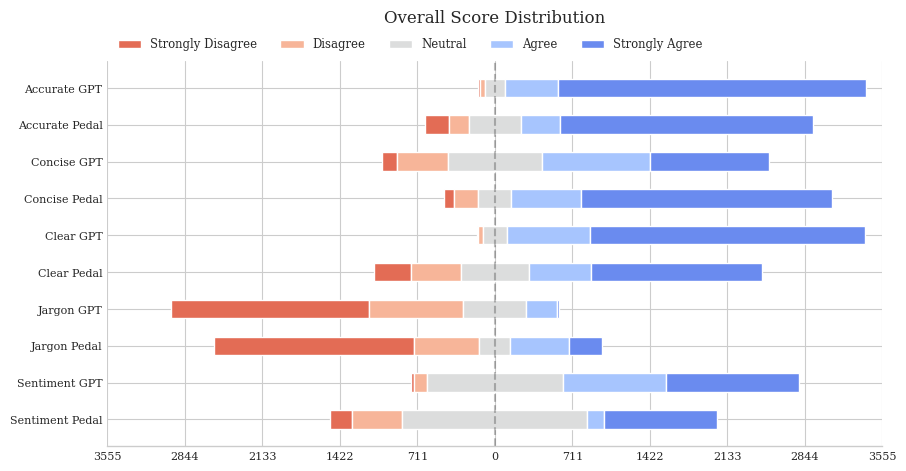

accurate:
	statistic = 7416140.5 
	pvalue = 1.3345305599820373e-58 
	effectsize = 0.5869767786064631
concise:
	statistic = 4068994.0 
	pvalue = 2.6215025992313417e-170 
	effectsize = 0.32196438921429577
clear:
	statistic = 8569803.0 
	pvalue = 1.2381505949262255e-185 
	effectsize = 0.6780966962796797
jargon:
	statistic = 5880865.0 
	pvalue = 4.1900361251383554e-08 
	effectsize = 0.46533101493310863
sentiment:
	statistic = 7939467.0 
	pvalue = 2.080211769693021e-87 
	effectsize = 0.6282205487012409


In [67]:
results = {category: list(v.values) for category, v in df.groupby('score_category').score.value_counts().unstack('score_category').items()}
results_sorted = {}
for data_field in data_fields:
    results_sorted[data_field.capitalize() + ' GPT'] = results['instructor_feedback_gpt_' + data_field]
    results_sorted[data_field.capitalize() + ' Pedal'] = results['instructor_feedback_pedal_' + data_field]
fig, ax = diverging_stacked_bar_chart(results_sorted, 'Overall Score Distribution')
plt.show()

for data_field in data_fields:
    gpt_scores = df[df.score_category == f'instructor_feedback_gpt_{data_field}']['score']
    pedal_scores = df[df.score_category == f'instructor_feedback_pedal_{data_field}']['score']
    U, p = st.mannwhitneyu(gpt_scores, pedal_scores)
    print(data_field + ':\n\tstatistic =', U, '\n\tpvalue =', p, '\n\teffectsize =', U / (len(gpt_scores) * len(pedal_scores)))

Create graphs for each temperature and top p combination displaying the score distribution, and display the significance values for each score category for each combination.

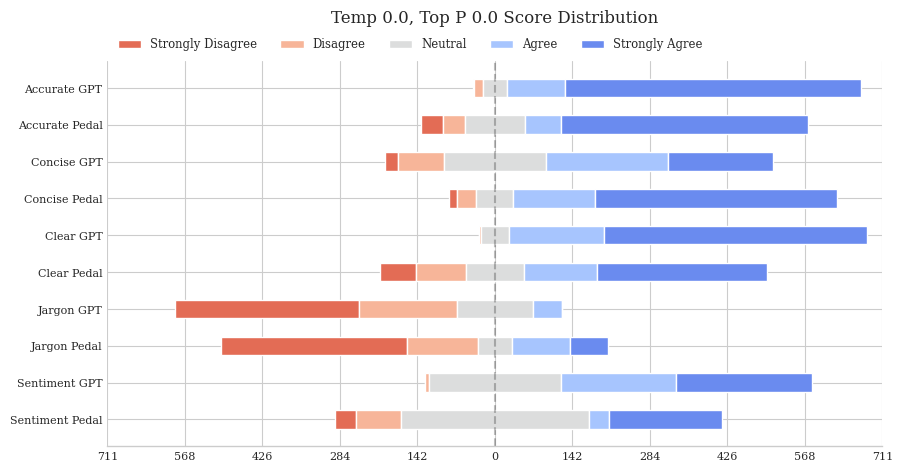

accurate:
	statistic = 293597.5 
	pvalue = 6.538151280114941e-11 
	effectsize = 0.5807820050996892
concise:
	statistic = 155329.5 
	pvalue = 9.551846905776574e-41 
	effectsize = 0.30726616698416087
clear:
	statistic = 336285.5 
	pvalue = 5.6640989543534744e-33 
	effectsize = 0.6652255791549708
jargon:
	statistic = 232725.0 
	pvalue = 0.005697427910533088 
	effectsize = 0.46036663165328445
sentiment:
	statistic = 325649.0 
	pvalue = 2.0157910417904412e-23 
	effectsize = 0.6441849102213361


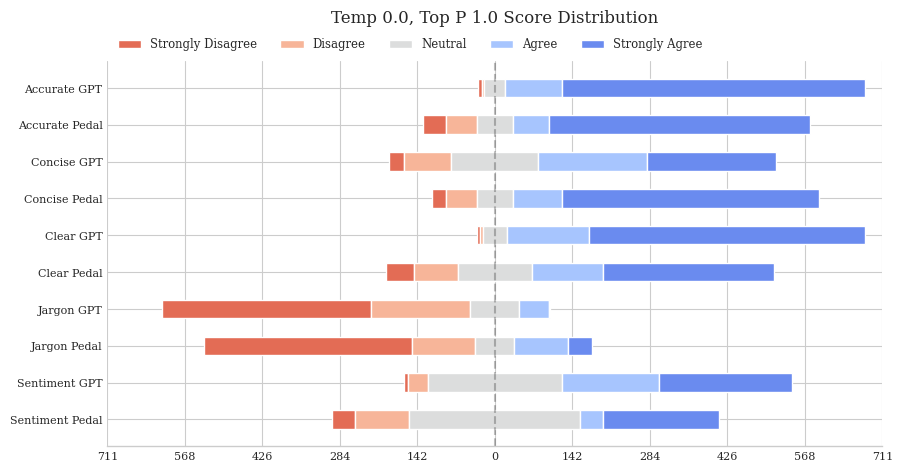

accurate:
	statistic = 288496.0 
	pvalue = 2.4025979538697123e-09 
	effectsize = 0.571494225550207
concise:
	statistic = 174344.0 
	pvalue = 1.1215311274319063e-27 
	effectsize = 0.3448798368415951
clear:
	statistic = 340218.5 
	pvalue = 1.3038714332575578e-36 
	effectsize = 0.6730056713766589
jargon:
	statistic = 235508.5 
	pvalue = 0.014631235581888473 
	effectsize = 0.46587283218699127
sentiment:
	statistic = 308800.5 
	pvalue = 2.4720085263148374e-14 
	effectsize = 0.610855928833817


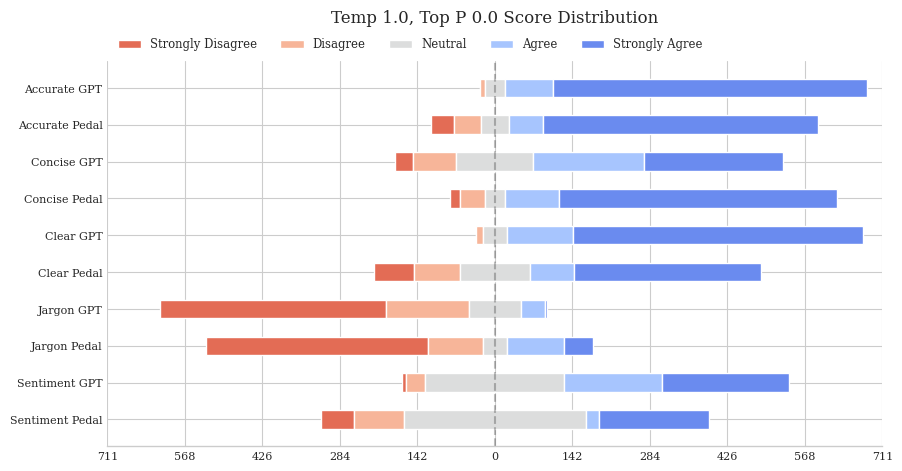

accurate:
	statistic = 284148.0 
	pvalue = 5.7245387575735966e-08 
	effectsize = 0.562089408748598
concise:
	statistic = 161599.5 
	pvalue = 4.0198596838481153e-38 
	effectsize = 0.31966921255496805
clear:
	statistic = 338098.5 
	pvalue = 1.4837019857309254e-36 
	effectsize = 0.6688119781374068
jargon:
	statistic = 234629.5 
	pvalue = 0.008827839508516901 
	effectsize = 0.46413403201845227
sentiment:
	statistic = 316833.5 
	pvalue = 2.368609776101903e-18 
	effectsize = 0.6267464655276438


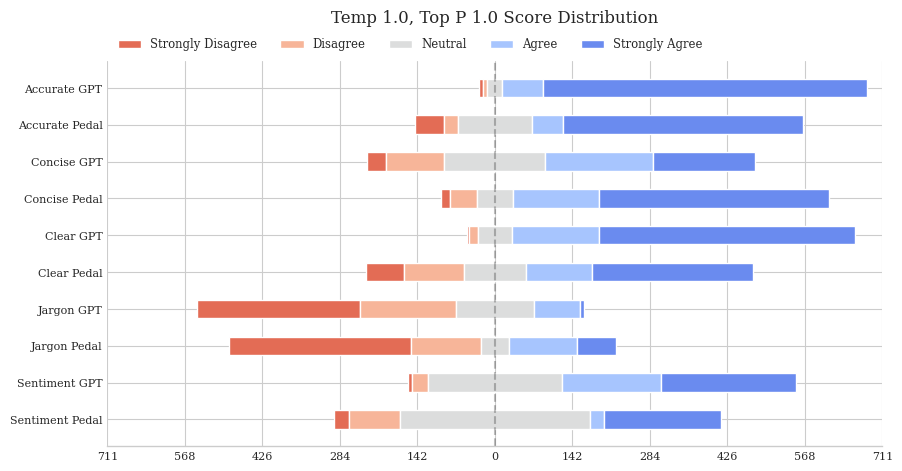

accurate:
	statistic = 314756.0 
	pvalue = 1.672068557133705e-24 
	effectsize = 0.6226368439688954
concise:
	statistic = 157707.0 
	pvalue = 2.548645953287208e-38 
	effectsize = 0.31196923569940715
clear:
	statistic = 338117.5 
	pvalue = 1.5352390880077655e-33 
	effectsize = 0.6688495631239849
jargon:
	statistic = 244424.0 
	pvalue = 0.255252835399048 
	effectsize = 0.48350909259951613
sentiment:
	statistic = 312015.0 
	pvalue = 4.721349404571831e-16 
	effectsize = 0.6172147151156925


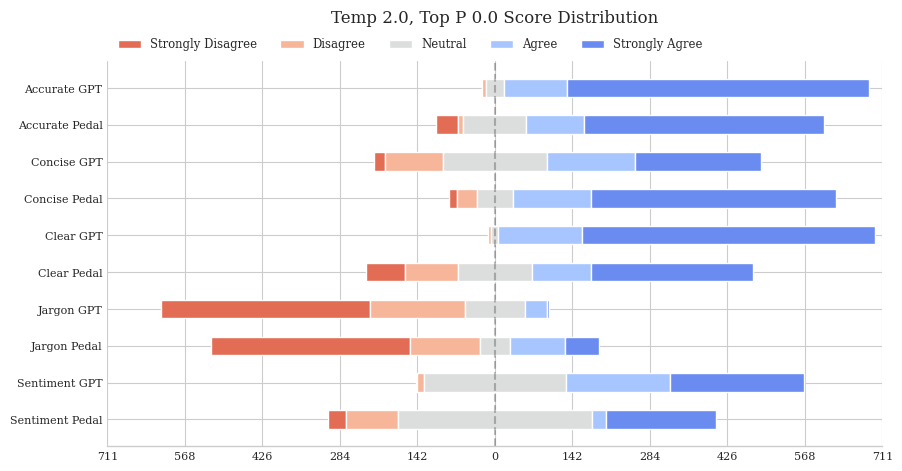

accurate:
	statistic = 301929.5 
	pvalue = 3.975270360611634e-15 
	effectsize = 0.5972640107928257
concise:
	statistic = 162612.5 
	pvalue = 1.1997809176263467e-35 
	effectsize = 0.3216730857867428
clear:
	statistic = 360991.0 
	pvalue = 9.220078690300425e-56 
	effectsize = 0.7140969415711711
jargon:
	statistic = 228061.0 
	pvalue = 0.000506629120892001 
	effectsize = 0.45114050652692966
sentiment:
	statistic = 325225.0 
	pvalue = 2.3910847534150097e-23 
	effectsize = 0.6433461715734856


In [68]:
temp_and_top_p_combos = [(temp, top_p) for temp in (0.0, 1.0, 2.0) for top_p in (0.0, 1.0) if not (temp == 2.0 and top_p == 1.0)]

for temp, top_p in temp_and_top_p_combos:
    results = {category: list(v.values) for category, v in df[(df.temp == temp) & (df.top_p == top_p)].groupby('score_category').score.value_counts().unstack('score_category').fillna(0.0).items()}
    results_sorted = {}
    for data_field in data_fields:
        results_sorted[data_field.capitalize() + ' GPT'] = results['instructor_feedback_gpt_' + data_field]
        results_sorted[data_field.capitalize() + ' Pedal'] = results['instructor_feedback_pedal_' + data_field]
    fig, ax = diverging_stacked_bar_chart(results_sorted, f'Temp {temp}, Top P {top_p} Score Distribution')
    plt.show()

    for data_field in data_fields:
        gpt_scores = df[(df.score_category == f'instructor_feedback_gpt_{data_field}') & (df.temp == temp) & (df.top_p == top_p)]['score']
        pedal_scores = df[(df.score_category == f'instructor_feedback_pedal_{data_field}') & (df.temp == temp) & (df.top_p == top_p)]['score']
        U, p = st.mannwhitneyu(gpt_scores, pedal_scores)
        print(data_field + ':\n\tstatistic =', U, '\n\tpvalue =', p, '\n\teffectsize =', U / (len(gpt_scores) * len(pedal_scores)))

Now compare the distribution by category.

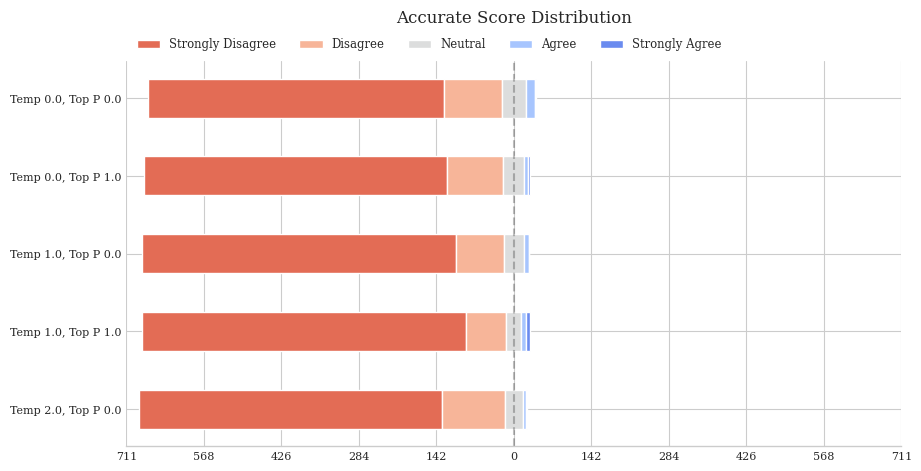

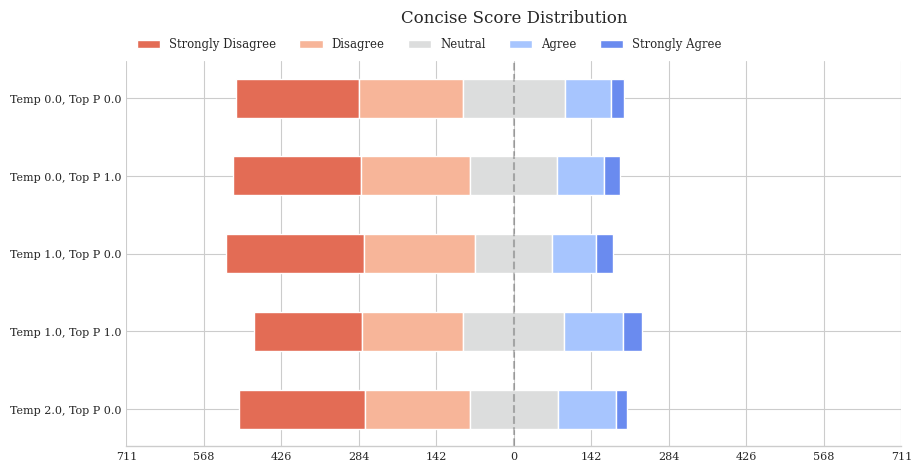

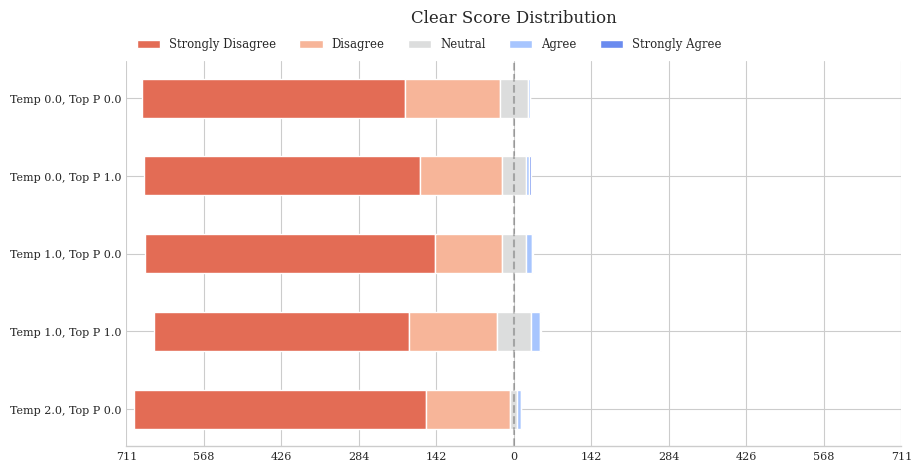

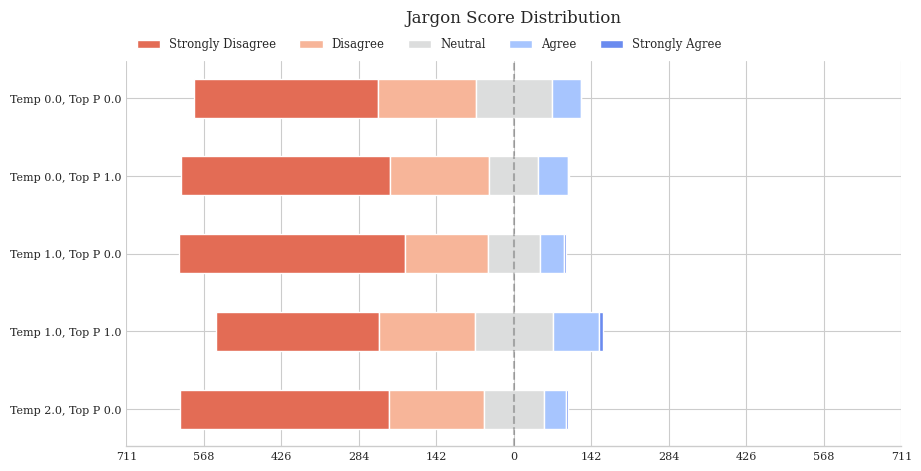

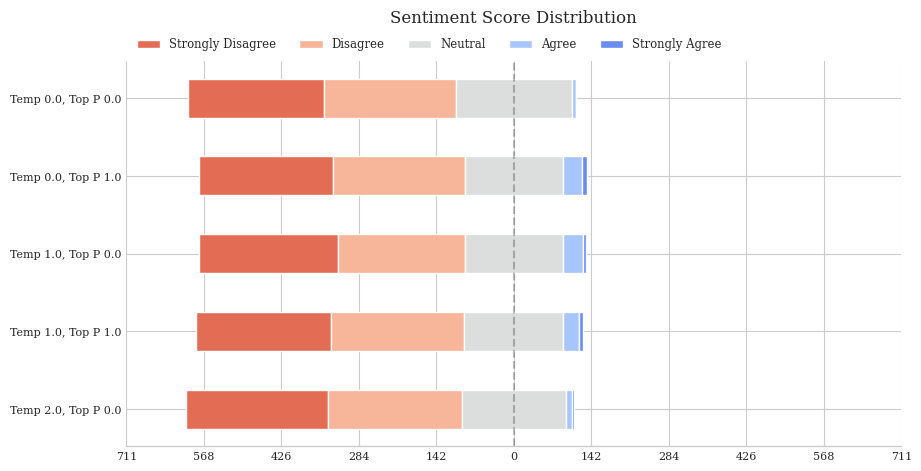

In [69]:
for data_field in data_fields:
    results = {}
    for temp, top_p in temp_and_top_p_combos:
        results[f'Temp {temp}, Top P {top_p}'] = \
            df[(df.score_category == f'instructor_feedback_gpt_{data_field}') & (df.temp == temp) & (df.top_p == top_p)].groupby('score_category').score.value_counts().tolist()
        if len(results[f'Temp {temp}, Top P {top_p}']) < 5:
            results[f'Temp {temp}, Top P {top_p}'].append(0)  # hack
    fig, ax = diverging_stacked_bar_chart(results, f'{data_field.capitalize()} Score Distribution')
    plt.show()

Create graphs for each student combination displaying the score distribution, and display the significance values for each score category for each combination.
Students are sorted based on competency in the overall course.

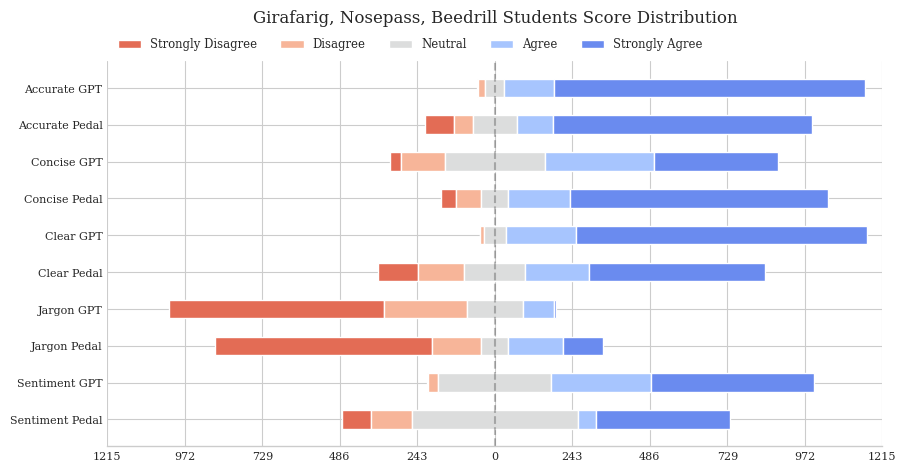

accurate:
	statistic = 857597.5 
	pvalue = 4.563534341516152e-19 
	effectsize = 0.5809395586716117
concise:
	statistic = 486109.5 
	pvalue = 2.437198183353026e-55 
	effectsize = 0.3292922826804857
clear:
	statistic = 1008066.5 
	pvalue = 1.955663183974611e-70 
	effectsize = 0.6828677877694795
jargon:
	statistic = 686871.5 
	pvalue = 0.0010619873161668487 
	effectsize = 0.46528916662432895
sentiment:
	statistic = 929573.5 
	pvalue = 1.0628390100901737e-31 
	effectsize = 0.6296963538755949


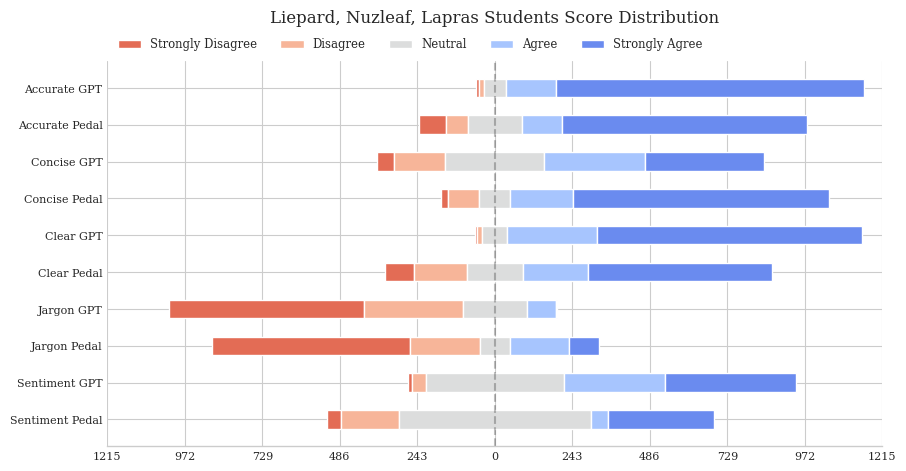

accurate:
	statistic = 880606.5 
	pvalue = 2.8373148957937656e-25 
	effectsize = 0.5970173083572314
concise:
	statistic = 467639.5 
	pvalue = 5.145417653759816e-63 
	effectsize = 0.3167806398076174
clear:
	statistic = 950312.0 
	pvalue = 3.798681975918753e-43 
	effectsize = 0.6437446866162001
jargon:
	statistic = 691240.0 
	pvalue = 0.0033919720195080888 
	effectsize = 0.46824840386797406
sentiment:
	statistic = 935470.0 
	pvalue = 1.0145627672071846e-33 
	effectsize = 0.6336906636860912


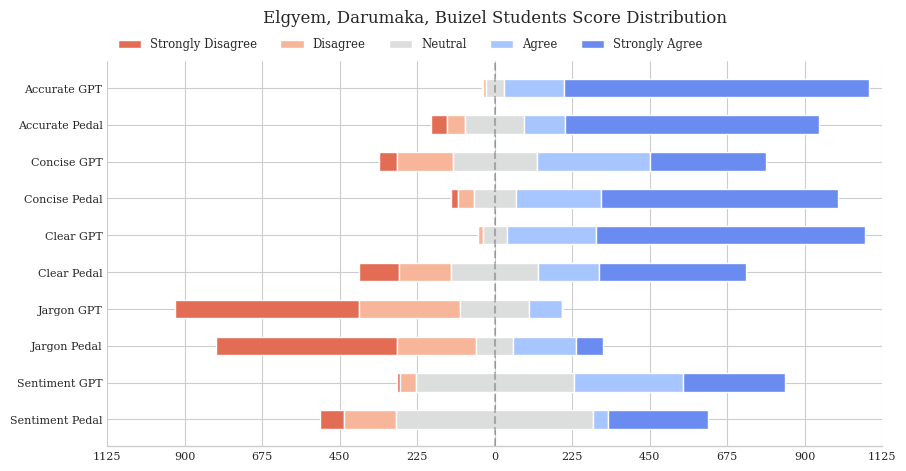

accurate:
	statistic = 737653.0 
	pvalue = 6.3183277904787854e-18 
	effectsize = 0.582836938271605
concise:
	statistic = 404579.0 
	pvalue = 5.912771634088558e-56 
	effectsize = 0.3196673580246914
clear:
	statistic = 899258.5 
	pvalue = 5.540659094216843e-80 
	effectsize = 0.7105252345679013
jargon:
	statistic = 585870.0 
	pvalue = 0.0011494484467692954 
	effectsize = 0.4629096296296296
sentiment:
	statistic = 786547.5 
	pvalue = 2.2756053161457173e-26 
	effectsize = 0.6214696296296296


In [70]:
#students = ('Girafarig', 'Nosepass', 'Beedrill', 'Liepard', 'Nuzleaf', 'Lapras', 'Elgyem', 'Darumaka', 'Buizel')
student_bundles = (
    ('Girafarig', 'Nosepass', 'Beedrill'),
    ('Liepard', 'Nuzleaf', 'Lapras'),
    ('Elgyem', 'Darumaka', 'Buizel')
)

for student_bundle in student_bundles:
    results = {category: list(v.values) for category, v in df[(df.student_name == student_bundle[0]) | (df.student_name == student_bundle[1]) | (df.student_name == student_bundle[2])].groupby('score_category').score.value_counts().unstack('score_category').fillna(0.0).items()}
    results_sorted = {}
    for data_field in data_fields:
        results_sorted[data_field.capitalize() + ' GPT'] = results['instructor_feedback_gpt_' + data_field]
        results_sorted[data_field.capitalize() + ' Pedal'] = results['instructor_feedback_pedal_' + data_field]
    fig, ax = diverging_stacked_bar_chart(results_sorted, f'{", ".join(student_bundle)} Students Score Distribution')
    plt.show()

    for data_field in data_fields:
        gpt_scores = df[(df.score_category == f'instructor_feedback_gpt_{data_field}') & ((df.student_name == student_bundle[0]) | (df.student_name == student_bundle[1]) | (df.student_name == student_bundle[2]))]['score']
        pedal_scores = df[(df.score_category == f'instructor_feedback_pedal_{data_field}') & ((df.student_name == student_bundle[0]) | (df.student_name == student_bundle[1]) | (df.student_name == student_bundle[2]))]['score']
        U, p = st.mannwhitneyu(gpt_scores, pedal_scores)
        print(data_field + ':\n\tstatistic =', U, '\n\tpvalue =', p, '\n\teffectsize =', U / (len(gpt_scores) * len(pedal_scores)))

Create graphs for each assignment combination displaying the score distribution, and display the significance values for each score category for each combination.
Assignments are sorted based on observed difficulty.

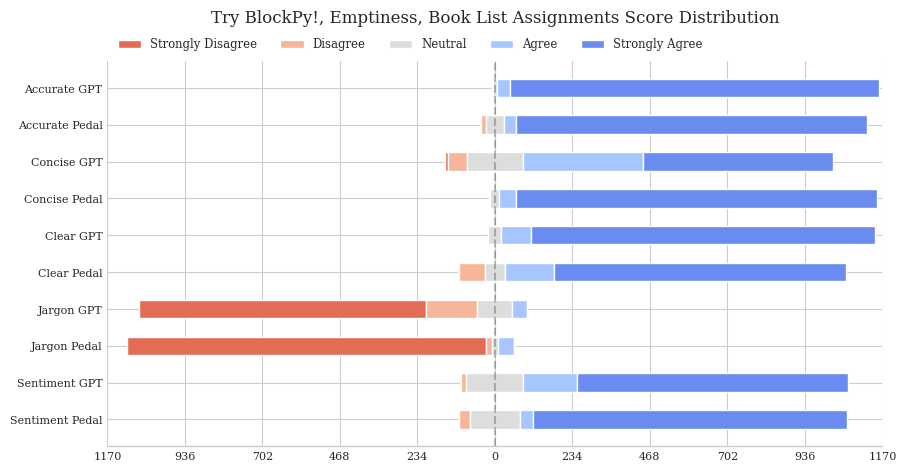

accurate:
	statistic = 716643.5 
	pvalue = 5.096495951956696e-06 
	effectsize = 0.5239656218698134
concise:
	statistic = 380156.5 
	pvalue = 1.5845850832017754e-120 
	effectsize = 0.2777094747607568
clear:
	statistic = 781565.5 
	pvalue = 5.879557840904418e-19 
	effectsize = 0.5709441887647015
jargon:
	statistic = 806223.0 
	pvalue = 1.728823839347836e-30 
	effectsize = 0.5889568266491343
sentiment:
	statistic = 622463.0 
	pvalue = 4.785645621339741e-07 
	effectsize = 0.4547176565125283


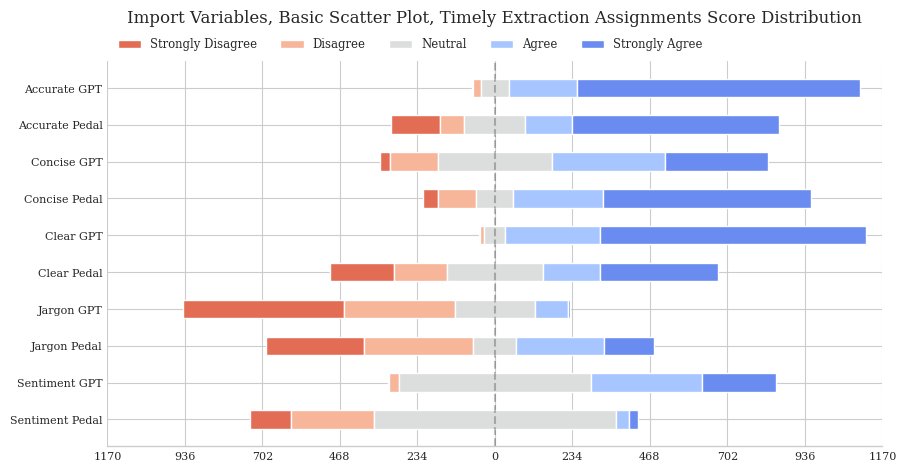

accurate:
	statistic = 860573.5 
	pvalue = 6.736411163258075e-36 
	effectsize = 0.6286606034041932
concise:
	statistic = 493598.5 
	pvalue = 1.6648585965258734e-34 
	effectsize = 0.36058039301629047
clear:
	statistic = 1042159.0 
	pvalue = 2.2232799966303217e-122 
	effectsize = 0.7613112718240923
jargon:
	statistic = 489902.0 
	pvalue = 5.968080507055554e-35 
	effectsize = 0.3578800496749215
sentiment:
	statistic = 1070088.5 
	pvalue = 3.980540880802895e-150 
	effectsize = 0.7817141500474833


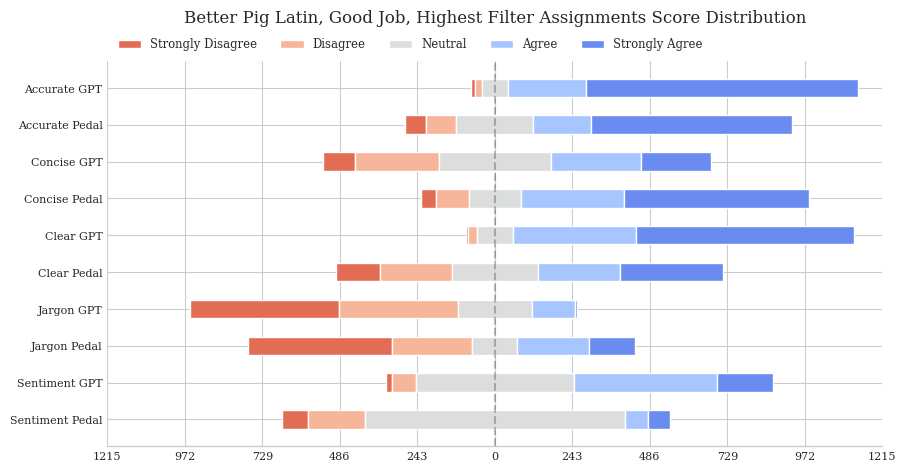

accurate:
	statistic = 916139.0 
	pvalue = 5.040999398504935e-32 
	effectsize = 0.6205957763891006
concise:
	statistic = 444746.5 
	pvalue = 7.891778074297194e-69 
	effectsize = 0.3012728411996816
clear:
	statistic = 1075755.5 
	pvalue = 1.3891299484747863e-93 
	effectsize = 0.7287205541160731
jargon:
	statistic = 638194.0 
	pvalue = 1.7657591979399285e-09 
	effectsize = 0.4323148571525343
sentiment:
	statistic = 1049061.0 
	pvalue = 1.317630550300834e-86 
	effectsize = 0.7106376060559874


In [71]:
assignments = {
    'bakery_intro_programs_code_try_blockpy': 'Try BlockPy!',
    'bakery_structures_lists_code_emptiness': 'Emptiness',
    'bakery_structures_lists_code_book_list': 'Book List',
    'bakery_intro_import_code_import_variable': 'Import Variables',
    'bakery_advanced_plotting_code_basic_scatter': 'Basic Scatter Plot',
    'bakery_functions_flow_code_timely_extraction': 'Timely Extraction',
    'bakery_if_patterns_make_pig_latin': 'Better Pig Latin',
    'bakery_nesting_list_dataclasses_code_good_job': 'Good Job',
    'bakery_for_composition_code_highest_filter': 'Highest Filter'
}
assignment_bundles = (
    ('bakery_intro_programs_code_try_blockpy', 'bakery_structures_lists_code_emptiness', 'bakery_structures_lists_code_book_list'),
    ('bakery_intro_import_code_import_variable', 'bakery_advanced_plotting_code_basic_scatter', 'bakery_functions_flow_code_timely_extraction'),
    ('bakery_if_patterns_make_pig_latin', 'bakery_nesting_list_dataclasses_code_good_job', 'bakery_for_composition_code_highest_filter')
)

for assignment_bundle in assignment_bundles:
    results = {category: list(v.values) for category, v in df[(df.assignment_name == assignment_bundle[0]) | (df.assignment_name == assignment_bundle[1]) | (df.assignment_name == assignment_bundle[2])].groupby('score_category').score.value_counts().unstack('score_category').fillna(0.0).items()}
    results_sorted = {}
    for data_field in data_fields:
        results_sorted[data_field.capitalize() + ' GPT'] = results['instructor_feedback_gpt_' + data_field]
        results_sorted[data_field.capitalize() + ' Pedal'] = results['instructor_feedback_pedal_' + data_field]
    fig, ax = diverging_stacked_bar_chart(results_sorted, f'{", ".join(map(lambda assignment: assignments[assignment], assignment_bundle))} Assignments Score Distribution')
    plt.show()

    for data_field in data_fields:
        gpt_scores = df[(df.score_category == f'instructor_feedback_gpt_{data_field}') & ((df.assignment_name == assignment_bundle[0]) | (df.assignment_name == assignment_bundle[1]) | (df.assignment_name == assignment_bundle[2]))]['score']
        pedal_scores = df[(df.score_category == f'instructor_feedback_pedal_{data_field}') & ((df.assignment_name == assignment_bundle[0]) | (df.assignment_name == assignment_bundle[1]) | (df.assignment_name == assignment_bundle[2]))]['score']
        U, p = st.mannwhitneyu(gpt_scores, pedal_scores)
        print(data_field + ':\n\tstatistic =', U, '\n\tpvalue =', p, '\n\teffectsize =', U / (len(gpt_scores) * len(pedal_scores)))

Create graphs for each student and assignment combination displaying the score distribution, and display the significance values for each score category for each combination.

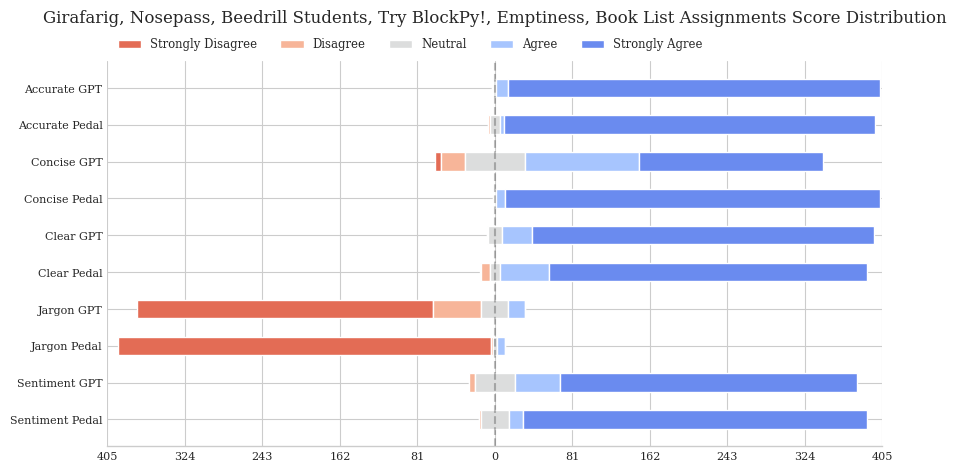

accurate:
	statistic = 2516684.5 
	pvalue = 1.4956710794828978e-76 
	effectsize = 0.7545884398869624
concise:
	statistic = 1869815.0 
	pvalue = 1.2095558969764467e-05 
	effectsize = 0.5606347493010112
clear:
	statistic = 2429119.0 
	pvalue = 1.2203777612473425e-61 
	effectsize = 0.7283332958540406
jargon:
	statistic = 428298.5 
	pvalue = 3.576286325742285e-155 
	effectsize = 0.12841859872420489
sentiment:
	statistic = 2263054.0 
	pvalue = 3.0894284395186653e-38 
	effectsize = 0.6785413059284745


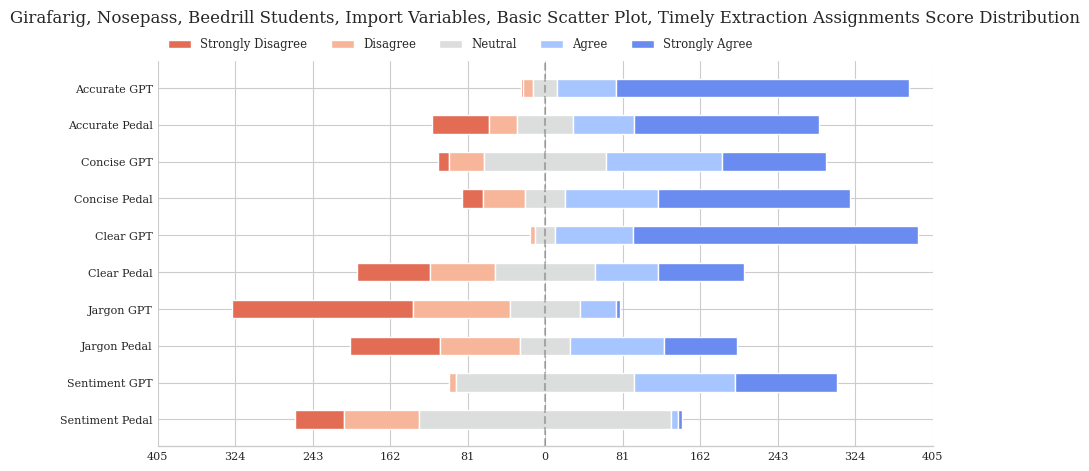

accurate:
	statistic = 2267940.0 
	pvalue = 1.0768116183448722e-38 
	effectsize = 0.6800062965211721
concise:
	statistic = 1550252.5 
	pvalue = 0.011562678479601136 
	effectsize = 0.4648189375370108
clear:
	statistic = 2274143.0 
	pvalue = 2.0241771185713037e-39 
	effectsize = 0.6818661689416597
jargon:
	statistic = 631157.0 
	pvalue = 3.1010648447247204e-109 
	effectsize = 0.18924254349471917
sentiment:
	statistic = 1592131.0 
	pvalue = 0.10493872942571794 
	effectsize = 0.47737555000862025


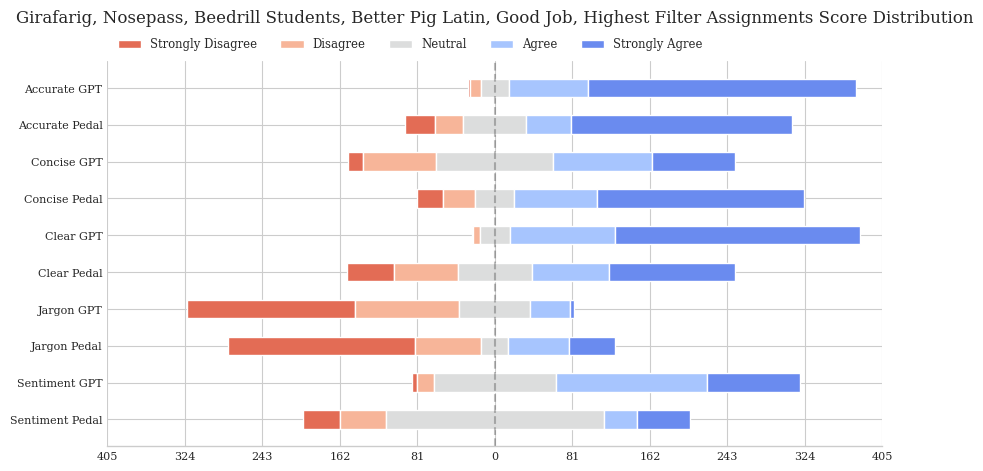

accurate:
	statistic = 2187808.0 
	pvalue = 1.6888988898719813e-29 
	effectsize = 0.655979971065986
concise:
	statistic = 1387725.5 
	pvalue = 1.6963362784948015e-09 
	effectsize = 0.41608776151176474
clear:
	statistic = 2143125.0 
	pvalue = 7.665789139557387e-25 
	effectsize = 0.6425824731835661
jargon:
	statistic = 672365.5 
	pvalue = 8.218149893944416e-101 
	effectsize = 0.201598266957506
sentiment:
	statistic = 1589994.0 
	pvalue = 0.09512861827523024 
	effectsize = 0.4767348040207785


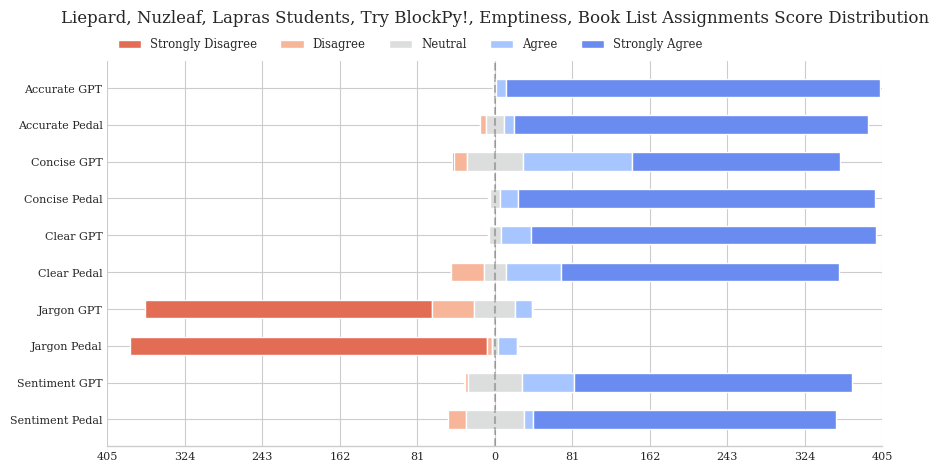

accurate:
	statistic = 2562325.0 
	pvalue = 2.0594299579691984e-84 
	effectsize = 0.7701746950651349
concise:
	statistic = 2022287.0 
	pvalue = 2.4285503886325363e-14 
	effectsize = 0.6063510910222102
clear:
	statistic = 2482426.0 
	pvalue = 3.325849812971662e-69 
	effectsize = 0.7443165650977834
jargon:
	statistic = 427495.0 
	pvalue = 1.9363744026261554e-153 
	effectsize = 0.12817768183078848
sentiment:
	statistic = 2240455.5 
	pvalue = 5.758606540952499e-35 
	effectsize = 0.6717654995614922


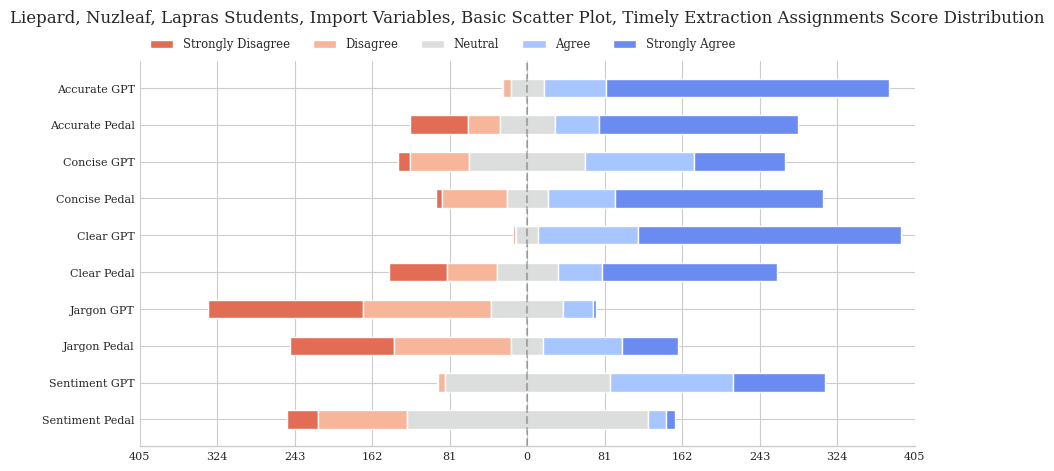

accurate:
	statistic = 2277249.0 
	pvalue = 2.5267350494078637e-39 
	effectsize = 0.6827974544064405
concise:
	statistic = 1487857.5 
	pvalue = 0.00012181782289053869 
	effectsize = 0.4461107737974769
clear:
	statistic = 2259319.5 
	pvalue = 4.5253108801341785e-37 
	effectsize = 0.6774215745800445
jargon:
	statistic = 622202.5 
	pvalue = 8.821560253887414e-110 
	effectsize = 0.18655767688352184
sentiment:
	statistic = 1621442.5 
	pvalue = 0.3244564660608348 
	effectsize = 0.48616414431026855


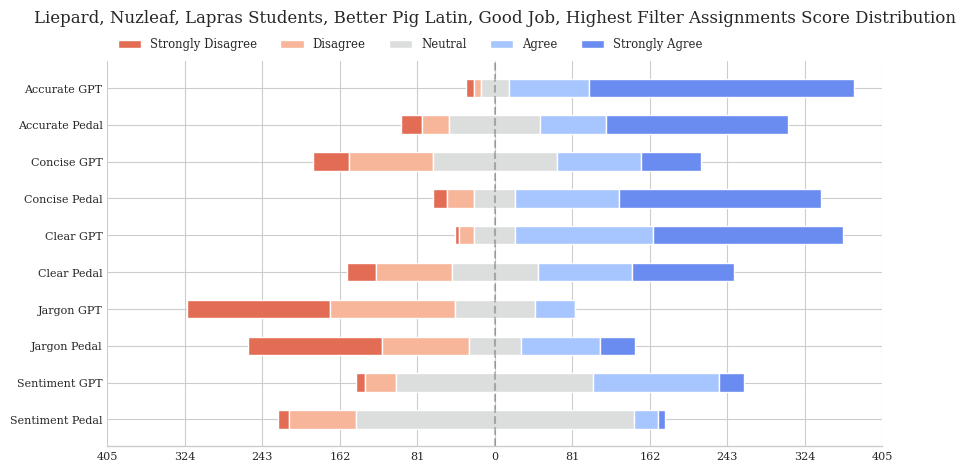

accurate:
	statistic = 2221318.0 
	pvalue = 1.2100565391802264e-32 
	effectsize = 0.6660274198505326
concise:
	statistic = 1230649.5 
	pvalue = 9.629901006926952e-21 
	effectsize = 0.3689909824821786
clear:
	statistic = 2000459.5 
	pvalue = 9.63280119236498e-13 
	effectsize = 0.5998064569325448
jargon:
	statistic = 671454.0 
	pvalue = 1.1106011515006188e-99 
	effectsize = 0.20132496795520474
sentiment:
	statistic = 1308291.5 
	pvalue = 1.895738280443003e-14 
	effectsize = 0.3922707204269641


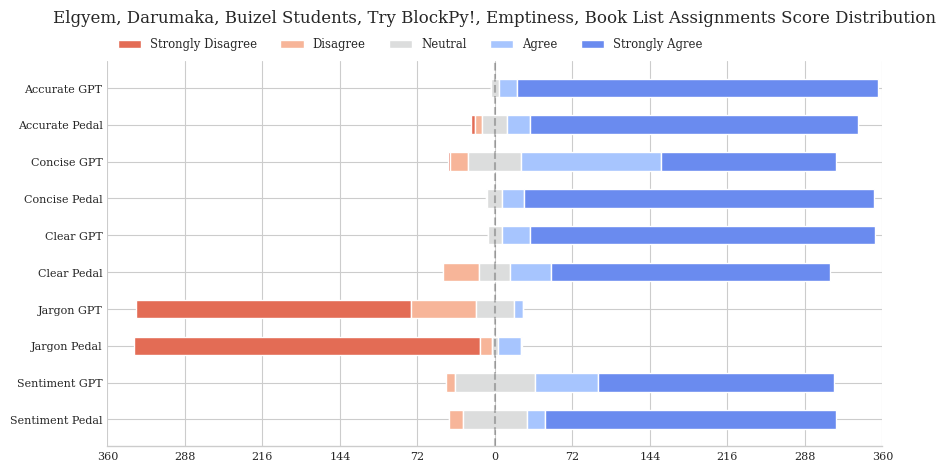

accurate:
	statistic = 2108653.0 
	pvalue = 2.3880729303671968e-68 
	effectsize = 0.7567660780935975
concise:
	statistic = 1602068.0 
	pvalue = 4.0009026493093737e-07 
	effectsize = 0.5749598047660063
clear:
	statistic = 2074147.0 
	pvalue = 6.633026810820269e-62 
	effectsize = 0.7443823571633649
jargon:
	statistic = 337392.0 
	pvalue = 1.3587549078566765e-142 
	effectsize = 0.12108527131782945
sentiment:
	statistic = 1734717.0 
	pvalue = 1.0585130220018239e-16 
	effectsize = 0.6225656761412576


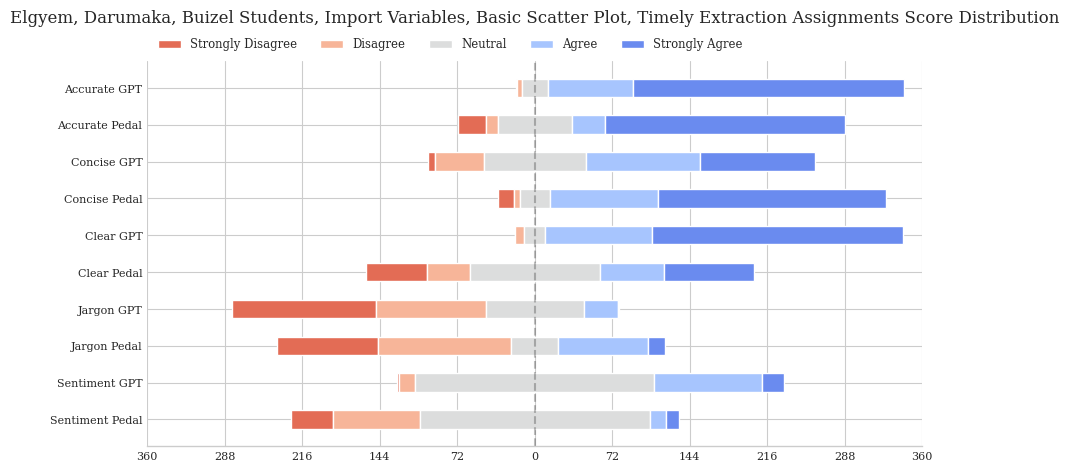

accurate:
	statistic = 1894888.5 
	pvalue = 7.16094890559096e-33 
	effectsize = 0.676118068935988
concise:
	statistic = 1333275.5 
	pvalue = 0.10135235201680658 
	effectsize = 0.47572807393134947
clear:
	statistic = 1858663.0 
	pvalue = 2.426380210231067e-28 
	effectsize = 0.6631923927781346
jargon:
	statistic = 560161.5 
	pvalue = 4.174969554479296e-90 
	effectsize = 0.19987208306572468
sentiment:
	statistic = 1075814.5 
	pvalue = 6.0527306943289964e-15 
	effectsize = 0.3838630200528081


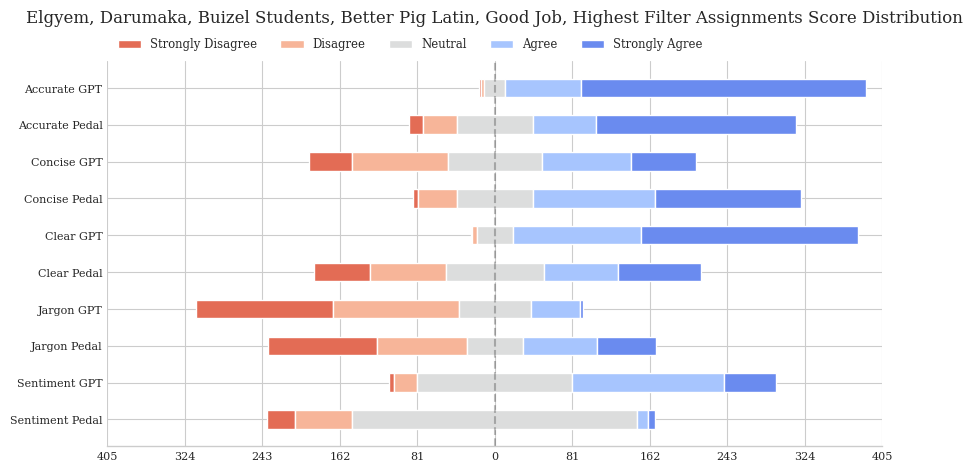

accurate:
	statistic = 2168896.5 
	pvalue = 1.7607998315360017e-41 
	effectsize = 0.6878998073217727
concise:
	statistic = 1161929.5 
	pvalue = 8.75426943740525e-21 
	effectsize = 0.3685243067944845
clear:
	statistic = 1998236.0 
	pvalue = 1.1647660173920227e-21 
	effectsize = 0.6337721322264247
jargon:
	statistic = 648453.5 
	pvalue = 7.059977523574029e-97 
	effectsize = 0.2056672772108439
sentiment:
	statistic = 1370070.0 
	pvalue = 3.2692068549550695e-06 
	effectsize = 0.43453935631199603


In [72]:
for student_bundle in student_bundles:
    for assignment_bundle in assignment_bundles:
        results = {category: list(v.values) for category, v in df[((df.assignment_name == assignment_bundle[0]) | (df.assignment_name == assignment_bundle[1]) | (df.assignment_name == assignment_bundle[2])) & ((df.student_name == student_bundle[0]) | (df.student_name == student_bundle[1]) | (df.student_name == student_bundle[2]))].groupby('score_category').score.value_counts().unstack('score_category').fillna(0.0).items()}
        results_sorted = {}
        for data_field in data_fields:
            results_sorted[data_field.capitalize() + ' GPT'] = results['instructor_feedback_gpt_' + data_field]
            results_sorted[data_field.capitalize() + ' Pedal'] = results['instructor_feedback_pedal_' + data_field]
        fig, ax = diverging_stacked_bar_chart(results_sorted, f'{", ".join(student_bundle)} Students, {", ".join(map(lambda assignment: assignments[assignment], assignment_bundle))} Assignments Score Distribution')
        plt.show()
    
        for data_field in data_fields:
            gpt_scores = df[(df.score_category == f'instructor_feedback_gpt_{data_field}') & ((df.assignment_name == assignment_bundle[0]) | (df.assignment_name == assignment_bundle[1]) | (df.assignment_name == assignment_bundle[2])) & ((df.student_name == student_bundle[0]) | (df.student_name == student_bundle[1]) | (df.student_name == student_bundle[2]))]['score']
            pedal_scores = df[(df.score_category == f'instructor_feedback_pedal_{data_field}') & ((df.assignment_name == assignment_bundle[0]) | (df.assignment_name == assignment_bundle[1]) | (df.assignment_name == assignment_bundle[2])) & (df.student_name == student_bundle[0]) | (df.student_name == student_bundle[1]) | (df.student_name == student_bundle[2])]['score']
            U, p = st.mannwhitneyu(gpt_scores, pedal_scores)
            print(data_field + ':\n\tstatistic =', U, '\n\tpvalue =', p, '\n\teffectsize =', U / (len(gpt_scores) * len(pedal_scores)))